# FrozenLake [8x8 | no random map | slip]

well this approach isnt very good
with only position of the player as state, how the hell will it go though random maps
it can barely work with current setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import cv2

plt.style.use(['dark_background', 'seaborn-v0_8'])

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


### Model

In [2]:
class FrozenLake8x8V0(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(FrozenLake8x8V0, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
        )

    def forward(self, x):
        return self.network(x)

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## Agent

In [4]:
class DQNAgent:
    def __init__(self, modelClass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=100):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Q-network and target network
        self.q_net = modelClass(state_size, action_size).to(device)
        self.target_net = modelClass(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Sync target network
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


## Training Loop

In [5]:
def create_env(render_mode=None):
    env = gym.make("FrozenLake8x8-v1",
                   is_slippery=True,
                   render_mode=render_mode)
    state_size = env.observation_space.n
    action_size = env.action_space.n  # 4 (left, down, right, up)

    return env, state_size, action_size


def one_hot_state(s, size):
    vec = np.zeros(size)
    vec[s] = 1.0
    return vec


def train_dqn(agent,
              env,
              state_size,
              action_size,
              episodes=2000,
              max_steps=100,
              epsilon_start=1.000,
              epsilon_end=0.010,
              epsilon_decay=0.9995, ):
    global history_rewards, history_epsilons

    scores = deque(maxlen=100)  # for moving average

    epsilon = epsilon_start

    print("Starting training...")
    for episode in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # FrozenLake gives sparse reward: 1 only if goal reached
            if not truncated and terminated:
                if reward == 0:  #fell into a hole
                    reward = -1
                else:  #completed game
                    reward = +1
            else:
                reward = reward - 0.02  # optional shaping to encourage speed

            next_state = one_hot_state(next_state, state_size)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Log every episode for smooth plot
        avg_score = np.mean(scores)
        history_rewards.append(avg_score)
        history_epsilons.append(epsilon)

        if episode % 100 == 0:
            avg_score = np.mean(scores)
            print(f"Episode {episode}, Avg Reward (last 100): {avg_score:.3f}, Epsilon: {epsilon:.3f}")

        if episode % 1000 == 0 and episode > 0:
            # render 1 episode, to check progress
            render_env, state_size, action_size = create_env(render_mode="human")
            evaluate_agent(agent, render_env, episodes=1, no_log=True)
            render_env.close()

    return agent, env


def evaluate_agent(agent, env, episodes=10, max_steps=100, no_log=False):
    state_size = env.observation_space.n

    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        for _ in range(max_steps):
            action = agent.act(state, epsilon=0.0)  # greedy
            state, reward, terminated, truncated, _ = env.step(action)
            state = one_hot_state(state, state_size)
            if terminated or truncated:
                if reward == 1.0:
                    success += 1
                break

    if not no_log:
        print(f"\nSuccess rate over {episodes} episodes: {success}/{episodes} ({100 * success / episodes:.1f}%)")


In [6]:
env, state_size, action_size = create_env()
agent = DQNAgent(modelClass=FrozenLake8x8V0,
                 state_size=state_size,
                 action_size=action_size,
                 lr=1e-4,
                 gamma=0.99,
                 buffer_size=50_000,
                 batch_size=128,
                 target_update=10)

history_rewards, history_epsilons = ([], [])

Starting training...
Episode 0, Avg Reward (last 100): -1.220, Epsilon: 0.995
Episode 100, Avg Reward (last 100): -1.707, Epsilon: 0.603
Episode 200, Avg Reward (last 100): -1.805, Epsilon: 0.365
Episode 300, Avg Reward (last 100): -1.786, Epsilon: 0.221
Episode 400, Avg Reward (last 100): -1.510, Epsilon: 0.134
Episode 500, Avg Reward (last 100): -1.255, Epsilon: 0.081
Episode 600, Avg Reward (last 100): -1.266, Epsilon: 0.049
Episode 700, Avg Reward (last 100): -1.115, Epsilon: 0.030
Episode 800, Avg Reward (last 100): -1.050, Epsilon: 0.018
Episode 900, Avg Reward (last 100): -1.029, Epsilon: 0.011
Episode 1000, Avg Reward (last 100): -1.116, Epsilon: 0.010
Episode 1100, Avg Reward (last 100): -0.989, Epsilon: 0.010
Episode 1200, Avg Reward (last 100): -1.139, Epsilon: 0.010
Episode 1300, Avg Reward (last 100): -0.826, Epsilon: 0.010
Episode 1400, Avg Reward (last 100): -0.767, Epsilon: 0.010
Episode 1500, Avg Reward (last 100): -0.926, Epsilon: 0.010
Episode 1600, Avg Reward (last 

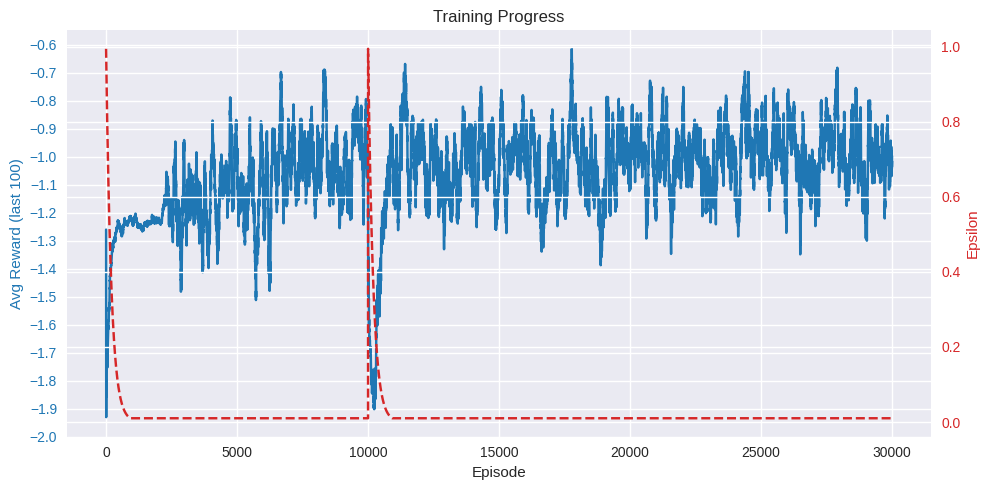

In [9]:
try:
    agent, env = train_dqn(
        agent=agent,
        env=env,
        state_size=state_size,
        action_size=action_size,
        episodes=50_000,
        max_steps=1_000,
        epsilon_start=1.000,
        epsilon_end=0.010,
        epsilon_decay=0.995,
    )
finally:
    # Plotting
    print(f"Model: {FrozenLake8x8V0.__name__}", agent.q_net)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Avg Reward (last 100)', color=color)
    ax1.plot(history_rewards, color=color, label='Avg Reward')
    ax1.tick_params(axis='y', labelcolor=color)

    if len(history_rewards) > 0:
        y_min = np.floor(min(history_rewards) * 10) / 10
        y_max = np.ceil(max(history_rewards) * 10) / 10
        ax1.set_yticks(np.arange(y_min, y_max + 0.05, 0.1))

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Epsilon', color=color)
    ax2.plot(history_epsilons, color=color, label='Epsilon', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Progress')
    fig.tight_layout()
    plt.show()

In [31]:
# env.close()

In [60]:
eval_env, state_size, action_size = create_env(render_mode="human")
evaluate_agent(agent, eval_env, episodes=1)
eval_env.close()


Success rate over 1 episodes: 0/1 (0.0%)


In [47]:
# # Record an env
# eval_env, state_size, action_size = create_env(render_mode="rgb_array")
# eval_env = RecordVideo(
#     eval_env,
#     video_folder="files",
#     name_prefix="frozenlake_8x8_slippery",# # Record an env
#     episode_trigger=lambda x: True
# )
# evaluate_agent(agent, eval_env, episodes=1, max_steps=1000)
# eval_env.close()
#
# # ffmpeg -i input.mp4 -vf "fps=10,scale=320:-1:flags=lanczos" -loop 0 output.gif


Success rate over 1 episodes: 1/1 (100.0%)


Exception ignored in: <function RecordVideo.__del__ at 0x7f702f3a60c0>
Traceback (most recent call last):
  File "/home/ezio4df/projects/play-FrozenLake/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py", line 433, in __del__
    if len(self.recorded_frames) > 0:
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'


In [48]:
MODEL_PATH = "files/dqn_frozenlake8x8_slippery.pth"

# save model
torch.save(agent.q_net.state_dict(), MODEL_PATH)

# load model
# agent.q_net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# agent.target_net.load_state_dict(agent.q_net.state_dict())  # Sync target net!

# Play by hand

In [39]:
import gymnasium as gym
import pygame
from pygame.locals import *
import sys

# env
env = gym.make(
    "FrozenLake8x8-v1",
    is_slippery=not True,
    render_mode="human"
)
state, info = env.reset()

# act map
KEY_TO_ACTION = {
    K_LEFT: 0,
    K_DOWN: 1,
    K_RIGHT: 2,
    K_UP: 3
}
ACTION_NAMES = ["LEFT", "DOWN", "RIGHT", "UP"]


def print_step_info(action, next_state, reward, terminated, truncated, info):
    print(f"Action: {ACTION_NAMES[action]} ({action})")
    print(f"NextState: {next_state}")
    print(f"Reward: {reward}")
    print(f"Terminated: {terminated}")
    print(f"Truncated: {truncated}")
    print(info)

    if terminated:
        if reward > 0:
            print("Reached the GOAL (G)!")
        else:
            print("Fell into a HOLE (H)!")
    elif truncated:
        print("!!max steps reached!!")

    print("-" * 60)


# game loop
running = True
clock = pygame.time.Clock()

try:
    while running:
        # Handle events
        for event in pygame.event.get():
            if event.type == QUIT:
                running = False
                break

            if event.type == KEYDOWN:
                if event.key == K_ESCAPE:
                    running = False
                    break

                if event.key in KEY_TO_ACTION:
                    action = KEY_TO_ACTION[event.key]

                    # act
                    next_state, reward, terminated, truncated, info = env.step(action)

                    # log
                    print_step_info(action, next_state, reward, terminated, truncated, info)

                    # restart
                    if terminated or truncated:
                        print("Press any arrow key to start new episode")
                        state, info = env.reset()
                        print(f"Intialized at position: {state}")
                    else:
                        state = next_state

        # render
        env.render()
        clock.tick(10)

except KeyboardInterrupt:
    pass

# Cleanup
env.close()
pygame.quit()
sys.exit()

Action: DOWN (1)
NextState: 8
Reward: 0
Terminated: False
Truncated: False
{'prob': 1.0}
------------------------------------------------------------
Action: UP (3)
NextState: 0
Reward: 0
Terminated: False
Truncated: False
{'prob': 1.0}
------------------------------------------------------------
Action: DOWN (1)
NextState: 8
Reward: 0
Terminated: False
Truncated: False
{'prob': 1.0}
------------------------------------------------------------


SystemExit: 

# FrozenLake2.0 [8x8 | no random map | slip]

use img as input of model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import cv2
from PIL import Image

plt.style.use(['dark_background', 'seaborn-v0_8'])

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


In [ ]:
class FrozenLakeImageWrapper(gym.ObservationWrapper):
    def __init__(self, env, img_size=(84, 84)):
        super().__init__(env)
        self.img_size = img_size
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(*img_size, 3),
            dtype=np.uint8
        )

    def observation(self, _):
        # Render current frame
        frame = self.env.render()
        if frame is None:
            return np.zeros((*self.img_size, 3), dtype=np.uint8)

        # Resize to 84x84
        img = Image.fromarray(frame)
        img = img.resize(self.img_size, Image.NEAREST)
        return np.array(img, dtype=np.uint8)